# Insurance claims case study

In this case study, we have at our disposal two distinct datasets: the first containing valuable customer demographics information, and the second comprising records of insurance claims made by these customers. Our primary objective in this assignment is to delve into these datasets to unearth meaningful insights for our case study. Furthermore, we aim to refine our understanding by conducting hypothesis testing to validate certain assumptions.


In [52]:
# Getting required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from datetime import datetime
import calendar
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

In [2]:
# Load the data from the Excel file
demographics = pd.read_csv('C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Datasets for ML\\EDA\\cust_demographics.csv')
claims = pd.read_csv('C:\\Users\\sujoydutta\\Desktop\\Data analysis\\Datasets for ML\\EDA\\claims.csv')

In [3]:
#examining the first dataset
demographics.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,47830476,Female,01-May-86,MA,413-187-7945,Silver
4,19269962,Male,13-May-77,NV,956-871-8691,Gold


In [4]:
#examining the first dataset
claims.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No
2,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1.0,Yes
3,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1.0,No
4,22890252,19269962,Crime,01/13/2018,Auto,No,Material only,$2680,1.0,No


In [5]:
# Performing the join operation
merged_data = pd.merge(claims, demographics, left_on='customer_id', right_on='CUST_ID', how='inner')
merged_data.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1.0,Yes,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,63017412,30308357,Driver error,04/04/2018,Auto,No,Material only,$1950,6.0,No,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
4,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1.0,No,47830476,Female,01-May-86,MA,413-187-7945,Silver


In [42]:
#dropping the redundant column
merged_data=merged_data.drop(['CUST_ID'],axis=1)
merged_data.head()

KeyError: "['CUST_ID'] not found in axis"

In [7]:
#examining the datatypes
merged_data.dtypes

claim_id                 int64
customer_id              int64
incident_cause          object
claim_date              object
claim_area              object
police_report           object
claim_type              object
claim_amount            object
total_policy_claims    float64
fraudulent              object
gender                  object
DateOfBirth             object
State                   object
Contact                 object
Segment                 object
dtype: object

In [8]:
#data cleaning and formatting 

merged_data['claim_amount'] = merged_data['claim_amount'].str.replace('$', '').astype(float)


merged_data['claim_id'] = merged_data['claim_id'].astype(str)

merged_data['DateOfBirth'] = pd.to_datetime(merged_data['DateOfBirth'], format='%d-%b-%y')

merged_data['claim_date'] = pd.to_datetime(merged_data['DateOfBirth'], format='%d-%b-%y')

C:\Users\sujoydutta\AppData\Local\Temp\ipykernel_9848\2503692354.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_data['claim_amount'] = merged_data['claim_amount'].str.replace('$', '').astype(float)


In [9]:
merged_data['police_report'].value_counts()

No         621
Unknown    296
Yes        168
Name: police_report, dtype: int64

In [10]:
# Creating a dictionary to map values to 'alert_flag'
alert_flag_mapping = {
    'No': 0,
    'Yes': 1,
    'Unknown': 'Unknown'
}

# Creating the 'alert_flag' column based on the 'police_reported' column
merged_data['alert_flag'] = merged_data['police_report'].map(alert_flag_mapping)
merged_data['alert_flag']

0             0
1       Unknown
2             0
3             0
4             0
         ...   
1080          1
1081          0
1082          1
1083          0
1084          0
Name: alert_flag, Length: 1085, dtype: object

In [11]:
# Sorting the DataFrame by 'claim_date' in descending order to ensure the most recent observation is retained
merged_data.sort_values(by='claim_date', ascending=False, inplace=True)

In [12]:
# Drop duplicates based on the 'customer_id' column, retaining only the first occurrence 
merged_data.drop_duplicates(subset='customer_id', keep='first', inplace=True)

In [13]:
#seeing the values count
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1078 entries, 462 to 648
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   claim_id             1078 non-null   object        
 1   customer_id          1078 non-null   int64         
 2   incident_cause       1078 non-null   object        
 3   claim_date           1078 non-null   datetime64[ns]
 4   claim_area           1078 non-null   object        
 5   police_report        1078 non-null   object        
 6   claim_type           1078 non-null   object        
 7   claim_amount         1013 non-null   float64       
 8   total_policy_claims  1068 non-null   float64       
 9   fraudulent           1078 non-null   object        
 10  gender               1078 non-null   object        
 11  DateOfBirth          1078 non-null   datetime64[ns]
 12  State                1078 non-null   object        
 13  Contact              1078 non-nu

In [14]:
# making a simple imputer
def get_imputation_strategy(value):
    if isinstance(value, (int, float)):
        return 'mean'
    else:
        return 'most_frequent'

In [15]:
# Building the custom function to create an imputer with the appropriate strategy for each column
imputation_strategies = merged_data.applymap(get_imputation_strategy)
imputer = SimpleImputer(strategy='most_frequent')

In [16]:
# Fitting the imputer on the DataFrame to impute missing values
merged_data_imputed = pd.DataFrame(imputer.fit_transform(merged_data), columns=merged_data.columns)
merged_data_imputed.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment,alert_flag
0,21491548,44643917,Other driver error,2068-12-19,Auto,Yes,Material and injury,41320.0,1.0,No,Male,2068-12-19,WA,278-698-5972,Gold,1
1,49457139,12499211,Other causes,2068-12-15,Auto,No,Material only,3139.5,1.0,Yes,Female,2068-12-15,MA,851-792-1325,Gold,0
2,25688619,98204394,Driver error,2068-12-06,Home,Unknown,Material only,1550.0,6.0,No,Male,2068-12-06,VA,685-823-5284,Silver,Unknown
3,44965194,18307355,Other causes,2068-11-09,Auto,Yes,Material and injury,34210.0,1.0,No,Male,2068-11-09,ID,879-542-1978,Platinum,1
4,87229793,44319192,Other causes,2068-11-07,Auto,Yes,Material and injury,41430.0,1.0,No,Male,2068-11-07,NC,432-234-3617,Platinum,1


In [17]:
# Calculating the current date
current_date = datetime.now()

# Calculating the age based on 'DateOfBirth' and current date
merged_data['age'] = (current_date - merged_data['DateOfBirth']).dt.days // 365
merged_data['age'] = merged_data['age'].abs()
merged_data['age'] 

462    46
978    46
306    46
859    46
63     46
       ..
712    54
18     54
688    54
988    54
648    54
Name: age, Length: 1078, dtype: int64

In [18]:
# Categorizing customers based on age
def categorize_age(age):
    if age < 18:
        return 'Children'
    elif 18 <= age <= 30:
        return 'Youth'
    elif 30 < age <= 60:
        return 'Adult'
    else:
        return 'Senior'

merged_data['age_segment'] = merged_data['age'].apply(categorize_age)
merged_data['age_segment']

462    Adult
978    Adult
306    Adult
859    Adult
63     Adult
       ...  
712    Adult
18     Adult
688    Adult
988    Adult
648    Adult
Name: age_segment, Length: 1078, dtype: object

In [19]:
#seeing number of people in each segment
merged_data['age_segment'].value_counts()

Adult    868
Youth    210
Name: age_segment, dtype: int64

In [20]:
# seeing the average amount by each segment
average_claim_by_segment = merged_data.groupby('age_segment')['claim_amount'].mean()
average_claim_by_segment

age_segment
Adult    12625.909646
Youth    11816.365979
Name: claim_amount, dtype: float64

In [21]:
# Calculate the reference date (1st October 2018)
reference_date = pd.to_datetime('2018-10-01')

# Filter claims made at least 20 days before 1st October 2018
filtered_data = merged_data[merged_data['claim_date'] <= reference_date - pd.DateOffset(days=20)]

# Group the filtered data by 'incident_cause' and calculate the total claim amount for each incident cause
total_claim_amount_by_cause = filtered_data.groupby('incident_cause')['claim_amount'].sum()
total_claim_amount_by_cause

incident_cause
Crime                  502877.0
Driver error          2660166.5
Natural causes        1001951.5
Other causes          3053369.0
Other driver error    2707723.0
Name: claim_amount, dtype: float64

In [23]:
# Filtering the data to include only adults 
adults_data = merged_data[merged_data['age_segment'] == 'Adult']

# Filtering the data to include only the specified states 
specified_states_data = adults_data[adults_data['State'].isin(['TX', 'DE', 'AK'])]

# Filtering the data to include only driver-related issues and causes
driver_related_data = specified_states_data[specified_states_data['incident_cause'].str.contains('driver', case=False)]

# Count the number of claims in this filtered data
num_adult_driver_claims = len(driver_related_data)
num_adult_driver_claims

29

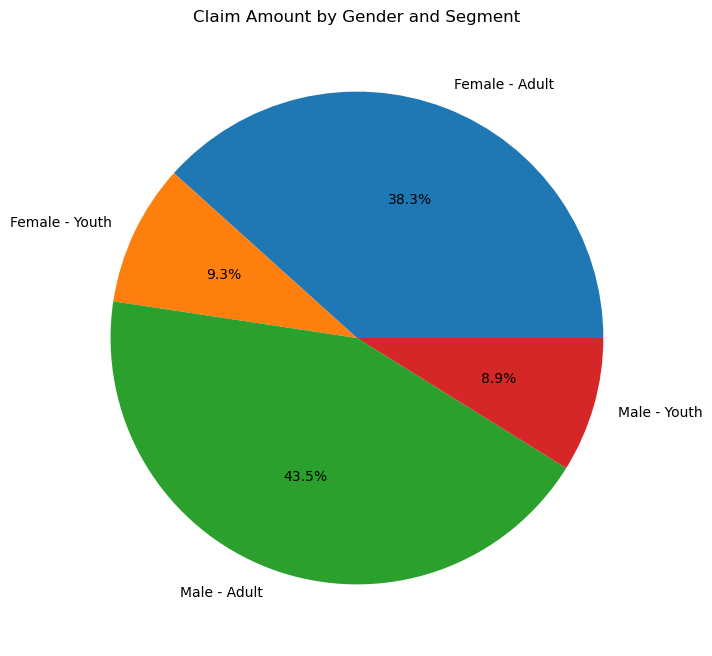

In [24]:
# Create a pie chart by 'gender' and 'age_segment' and calculating the total claim amount
grouped_data = merged_data.groupby(['gender', 'age_segment'])['claim_amount'].sum()
grouped_data = grouped_data.reset_index()
plt.figure(figsize=(8, 8))
plt.pie(grouped_data['claim_amount'], labels=grouped_data.apply(lambda row: f"{row['gender']} - {row['age_segment']}", axis=1), autopct='%1.1f%%')
plt.title("Claim Amount by Gender and Segment")
plt.show()

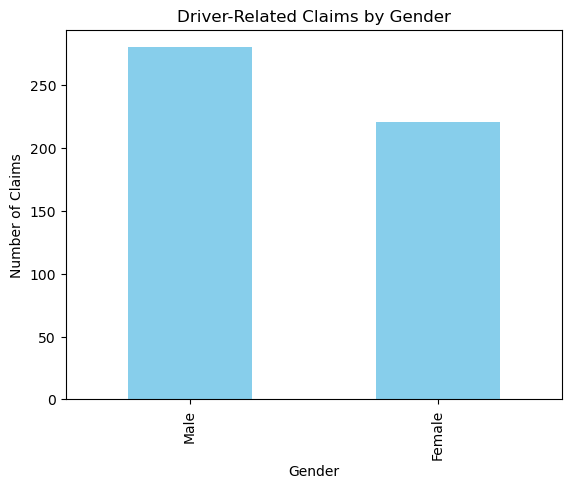

In [25]:
# Determining which gender has claimed the most for driver-related issues
driver_related_data = merged_data[merged_data['incident_cause'].str.contains('driver', case=False)]


gender_claim_counts = driver_related_data['gender'].value_counts()


gender_claim_counts.plot(kind='bar', color='skyblue')
plt.title("Driver-Related Claims by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Claims")
plt.show()




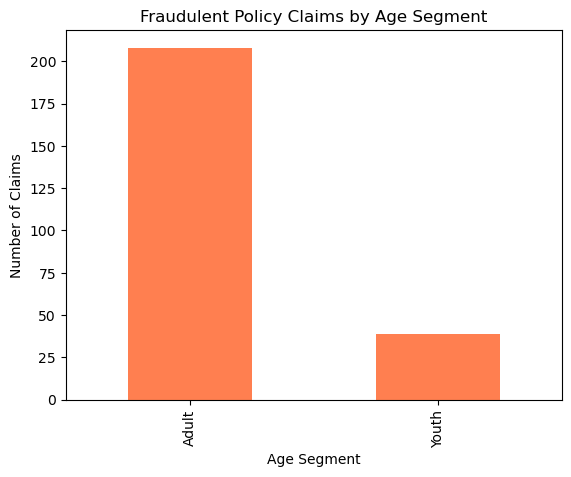

In [28]:
# Seeing which segment has the most fraudulent claims
fraudulent_data = merged_data[merged_data['fraudulent'] == 'Yes']


age_claim_counts = fraudulent_data['age_segment'].value_counts()

age_claim_counts.plot(kind='bar', color='coral')
plt.title("Fraudulent Policy Claims by Age Segment")
plt.xlabel("Age Segment")
plt.ylabel("Number of Claims")
plt.show()

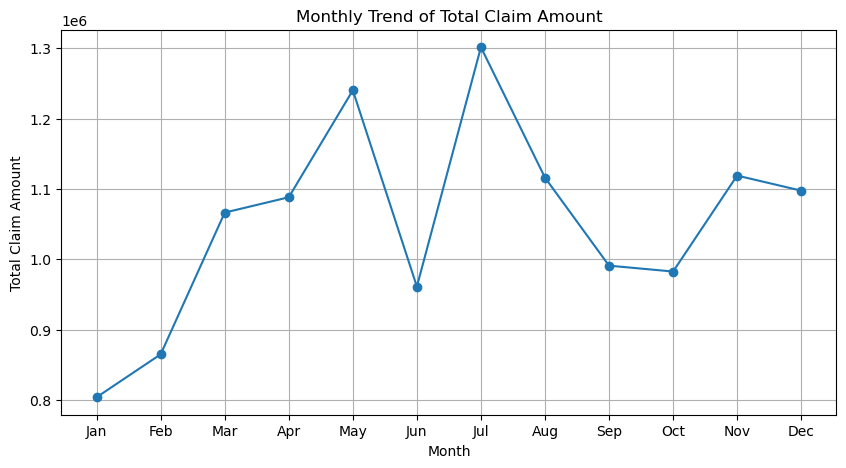

In [37]:
# Creating a line chart to visualize the monthly trend of amount claimed 
merged_data['claim_month'] = merged_data['claim_date'].dt.month


monthly_claim_totals = merged_data.groupby('claim_month')['claim_amount'].sum()


monthly_claim_totals = monthly_claim_totals.reindex(range(1, 13))

plt.figure(figsize=(10, 5))
plt.plot(monthly_claim_totals.index, monthly_claim_totals.values, marker='o', linestyle='-')
plt.title("Monthly Trend of Total Claim Amount")
plt.xlabel("Month")
plt.ylabel("Total Claim Amount")
plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])  # Display month abbreviations
plt.grid(True)
plt.show()

In [39]:
# Grouping the data by 'gender', 'age_segment', and 'fraudulent', and calculating the average claim amount
average_claim_amount = merged_data.groupby(['gender', 'age_segment', 'fraudulent'])['claim_amount'].mean().reset_index()
average_claim_amount

,gender,age_segment,fraudulent,claim_amount
0,Female,Adult,No,12181.540984
1,Female,Adult,Yes,11382.095960
2,Female,Youth,No,13381.298701
3,Female,Youth,Yes,8448.441176
4,Male,Adult,No,12237.327044
5,Male,Adult,Yes,16566.520619
6,Male,Youth,No,11933.734940
7,Male,Youth,Yes,7523.029412


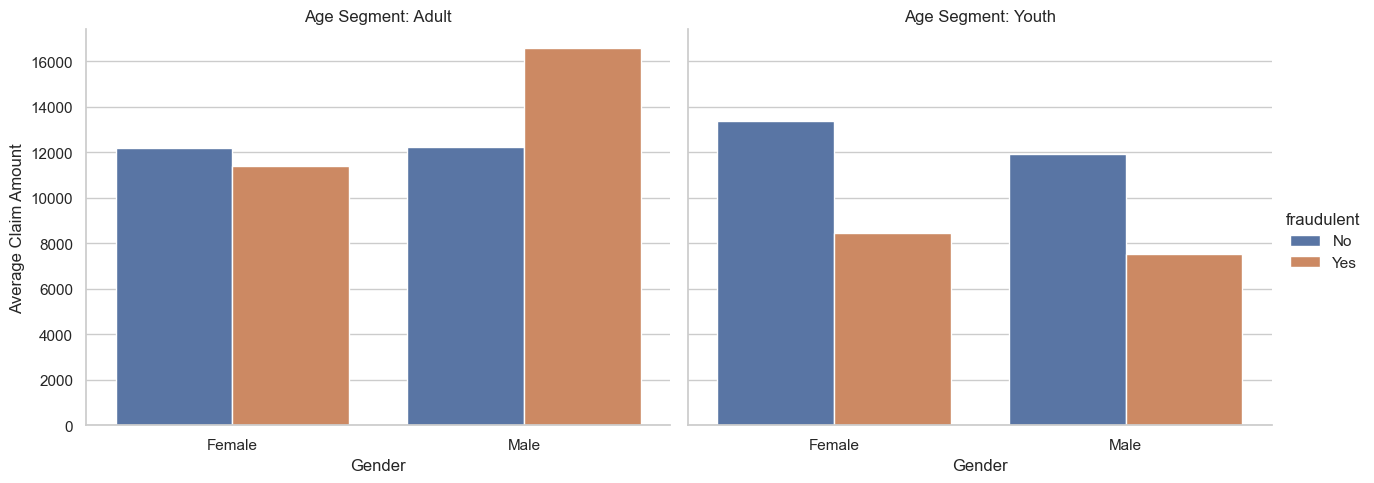

In [40]:
# Creating a facetted bar chart
sns.set(style="whitegrid")
g = sns.catplot(
    data=average_claim_amount, kind="bar",
    x="gender", y="claim_amount", hue="fraudulent",
    col="age_segment", aspect=1.3,
)
g.set_axis_labels("Gender", "Average Claim Amount")
g.set_titles("Age Segment: {col_name}")
plt.show()

# **Is there any similarity in the amount claimed by males and females?**

We will use t-test to compare the means of the claim amounts for males and females. 

In [43]:
# Separate the claim amounts for males and females
male_claim_amounts = merged_data[merged_data['gender'] == 'Male']['claim_amount']
female_claim_amounts = merged_data[merged_data['gender'] == 'Female']['claim_amount']


In [44]:
# Performing a t-test to compare the means
t_stat, p_value = stats.ttest_ind(male_claim_amounts, female_claim_amounts, equal_var=False)


In [45]:
# Checking the p-value to determine if there's a significant difference
if p_value < 0.05:  # Adjust the significance level as needed
    print("There is a significant difference in the amounts claimed by males and females.")
else:
    print("There is no significant difference in the amounts claimed by males and females.")

There is no significant difference in the amounts claimed by males and females.


# Is there any relationship between age category and segment?
To determine if there is a relationship between two categorical variables like "age category" and "segment," you can perform a chi-squared test of independence. The chi-squared test can assess whether there is a statistically significant association between these categorical variables

In [54]:
# Creating a contingency table
contingency_table = pd.crosstab(merged_data['age_segment'], merged_data['Segment'])
contingency_table

Segment,Gold,Platinum,Silver
age_segment,,,
Adult,300,291,277
Youth,71,70,69


In [55]:
# Performing the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)


In [56]:
# Checking the p-value to determine if there is a significant relationship
if p < 0.05:  
    print("There is a significant relationship between age category and segment.")
else:
    print("There is no significant relationship between age category and segment.")

There is no significant relationship between age category and segment.


# Is there any difference between age groups and insurance claims?

To determine if there is any difference between age groups and insurance claims performance (ANOVA) between insurance claims in different age segments, we will perform an Analysis of Variance (ANOVA) test. The ANOVA test assesses whether there are statistically significant differences in the means of multiple groups.

In [58]:
# Creating a list of insurance claims for each age segment
age_segments = merged_data['age_segment'].unique()
claims_data = [merged_data[merged_data['age_segment'] == segment]['claim_amount'] for segment in age_segments]


In [59]:
# Performing the ANOVA test
f_statistic, p_value = stats.f_oneway(*claims_data)

In [60]:
# Checking the p-value to determine if there are significant differences
if p_value < 0.05:  
    print("There are significant differences in insurance claim amount between different age segments.")
else:
    print("There are no significant differences in insurance claim amount between different age segments.")

There are no significant differences in insurance claims between different age segments.


# The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was 10000
To determine if the current year has shown a significant rise in claim amounts compared to the 2016-17 fiscal average, we will perform a statistical analysis and compare the claim amounts for these two time periods.

In [61]:
# Extract the year from 'claim_date'
merged_data['claim_year'] = merged_data['claim_date'].dt.year
merged_data['claim_year']


462    2068
978    2068
306    2068
859    2068
63     2068
       ... 
712    1969
18     1969
688    1969
988    1969
648    1969
Name: claim_year, Length: 1078, dtype: int64

In [62]:
# Finding the most recent year in the dataset
recent_year = merged_data['claim_year'].max()
recent_year

2068

In [66]:
# Calculating the mean of all existing values for the most recent claim year
most_recent_claim_year_mean = merged_data[merged_data['claim_year'] == recent_year].mean().round()
most_recent_claim_year_mean

C:\Users\sujoydutta\AppData\Local\Temp\ipykernel_9848\997251540.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  most_recent_claim_year_mean = merged_data[merged_data['claim_year'] == recent_year].mean().round()
C:\Users\sujoydutta\AppData\Local\Temp\ipykernel_9848\997251540.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  most_recent_claim_year_mean = merged_data[merged_data['claim_year'] == recent_year].mean().round()


claim_id               8.954812e+187
customer_id             4.608128e+07
claim_amount            1.524200e+04
total_policy_claims     2.000000e+00
age                     4.500000e+01
claim_month             8.000000e+00
claim_year              2.068000e+03
dtype: float64

In [67]:
# Calculating the average claim amount for the 2016-17 fiscal year
fiscal_year_2016_17 = range(2016, 2018)  
fiscal_year_average = merged_data[merged_data['claim_year'].isin(fiscal_year_2016_17)]['claim_amount'].mean()


In [71]:
# Comparing the two averages
if most_recent_claim_year_mean['claim_amount'] > fiscal_year_average:
    print(f"The current year has shown a significant rise in claim amounts compared to 2016-17 fiscal year.")
else:
    print(f"The current year has not shown a significant rise in claim amounts compared to 2016-17 fiscal year.")

The current year has not shown a significant rise in claim amounts compared to 2016-17 fiscal year.


# Is there any relationship between the total number of policy claims and the claimed amount?

For answering this question, the number of claims has to be grouped per customer ID and the claim amount needs to be summed per ID. Then a correlation test needs to be taken. 

In [47]:
# Grouping by customer_id and making a separate dataset
customer_claim_data = merged_data.groupby('customer_id').agg({'claim_id': 'count', 'claim_amount': 'sum'})
customer_claim_data


,claim_id,claim_amount
customer_id,,
154557,1,0.0
263204,1,39192.0
287476,1,1621.5
441097,1,37040.0
524545,1,35250.0
...,...,...
99674324,1,21480.0
99723844,1,14360.0
99761663,1,1242.0


In [48]:
# Renaming the columns for clarity
customer_claim_data = customer_claim_data.rename(columns={'claim_id': 'number_of_claims', 'claim_amount': 'total_claim_amount'})

customer_claim_data

,number_of_claims,total_claim_amount
customer_id,,
154557,1,0.0
263204,1,39192.0
287476,1,1621.5
441097,1,37040.0
524545,1,35250.0
...,...,...
99674324,1,21480.0
99723844,1,14360.0
99761663,1,1242.0


In [49]:
# Resetting the index to make customer_id a regular column
customer_claim_data = customer_claim_data.reset_index()
customer_claim_data


,customer_id,number_of_claims,total_claim_amount
0,154557,1,0.0
1,263204,1,39192.0
2,287476,1,1621.5
3,441097,1,37040.0
4,524545,1,35250.0
...,...,...,...
1073,99674324,1,21480.0
1074,99723844,1,14360.0
1075,99761663,1,1242.0
1076,99892000,1,2415.0


In [51]:
# checking the correlation
correlation_coefficient = customer_claim_data['number_of_claims'].corr(customer_claim_data['total_claim_amount'])

# Check the correlation coefficient to assess the relationship
if correlation_coefficient > 0:
    print("There is a positive relationship between the total number of policy claims and the claimed amount.")
elif correlation_coefficient < 0:
    print("There is a negative relationship between the total number of policy claims and the claimed amount.")
else:
    print("There is no significant relationship between the total number of policy claims and the claimed amount.")

There is no significant relationship between the total number of policy claims and the claimed amount.
